In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import floor, ceil

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'narrow_search_factor'
model_type = 'prediction'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes2/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes2/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes2/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
load = False

In [6]:
if load:
    with open('pickles/resolution_prediction.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    truncate = False
    summary_stats = {}

    for param in os.listdir(exp_dir):
        if param == '.DS_Store': continue
        dirpath = os.path.join(exp_dir, param)
        for site_spacing in os.listdir(dirpath):
            if not site_spacing.startswith('res'): continue    
            dirpath = os.path.join(exp_dir, param, site_spacing)
            for seed in os.listdir(dirpath):
                if not seed.startswith('seed'): continue
                dirpath = os.path.join(exp_dir, param, site_spacing, seed)
                _param = round(float(param), 1)
                _seed = int(seed[4:])
                _site_spacing = int(site_spacing[3:])
                if truncate and (_seed > 5 or _param > 0.6): continue
                cache_states = [0, _site_spacing, 66]

                try:
                    with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                        _results = pickle.load(f)
                except:
                    continue

                readout = np.linalg.norm(_results['narrow_reconstruct'], axis=1)
                readout /= readout.max()
                reconstruct = _results['narrow_reconstruct']
                activations = _results['narrow_acts'].copy()
                _summary_stats = get_resolution_summary_statistics(
                    readout, reconstruct, cache_states, activations,
                    inputs, _site_spacing, search_strength=_param)
                for key, _dict in _summary_stats.items():
                    n_samples = len(_dict[list(_dict.keys())[0]])
                    if key not in summary_stats.keys():
                        summary_stats[key] = _dict
                    else:
                        for nested_key in _dict.keys():
                            summary_stats[key][nested_key].extend(_dict[nested_key])

    with open('pickles/resolution_prediction.p', 'wb') as f:
        pickle.dump(summary_stats, f)

/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:124: RuntimeWarning: invalid value encountered in greater
  high_readout = (readout > 0.5).tolist()
/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:141: RuntimeWarning: invalid value encountered in true_divide
  r = reconstruct[idx]/reconstruct[idx].max()
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Identifying the Presence of a Cache

### Sensitivity/Specificity at different thresholds

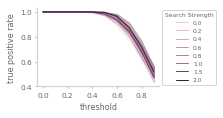

In [11]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df['site spacing']>15]
fig, ax = plt.subplots(figsize=(3.2,1.75))
sns.lineplot(
    x='threshold', y='sensitivity', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(
    title='Search Strength',
    loc='center left', labels=formatted_labels,
    bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.ylabel('true positive rate')
plt.savefig('figures/figS6b_a.svg', dpi=300, transparent=True)
plt.show()

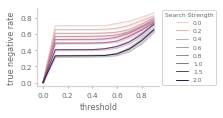

In [12]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df['site spacing']>15]
fig, ax = plt.subplots(figsize=(3.2,1.75))
sns.lineplot(
    x='threshold', y='specificity', hue='search strength',
    ax=ax, data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(
    title='Search Strength',
    loc='center left', labels=formatted_labels,
    bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.ylabel('true negative rate')
plt.savefig('figures/figS6b_b.svg', dpi=300, transparent=True)
plt.show()

### Are you correct at sites between cache 1 and cache 2?

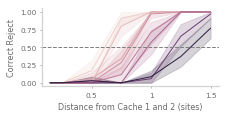

In [9]:
df = pd.DataFrame(summary_stats['identification_2'])
df['binarized'] = df['noncache val'] < 0.5
fig, ax = plt.subplots(figsize=(3.2,1.75))
sns.lineplot(
    x='site spacing', y='binarized',
    ax=ax, data=df,
    hue='search strength')
ax.axhline(0.5, color='gray', linestyle='--')
ax.get_legend().remove()
plt.xlabel('Distance from Cache 1 and 2 (sites)')
plt.ylabel('Correct Reject')
plt.xticks([10, 20, 30], [0.5, 1, 1.5])
plt.tight_layout()
plt.savefig('figures/figS6b_c.svg', dpi=300, transparent=True)
plt.show()

# Reconstruction

### Probability of valid attractor given optimal attractor distance

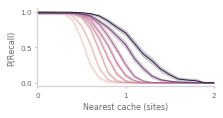

In [10]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df['site spacing']>15]
df['val'] = df['is_closest'] & df['high_readout']
fig, ax = plt.subplots(figsize=(3.2,1.75))
sns.lineplot(
    x='distance from closest cache', y='val', hue='search strength',
    data=df
    )
hue_values = df['search strength'].unique()
formatted_labels = sorted([f'{val:.1f}' for val in hue_values])
#ax.legend(title='Search Strength', labels=formatted_labels, bbox_to_anchor=(1., 1))
ax.get_legend().remove()
plt.ylabel('P(Recall)')
plt.xlabel('Nearest cache (sites)')
plt.yticks([0, 0.5, 1.0])
plt.xticks([0, 10, 20], [0,1,2])
plt.xlim([0, 20])
plt.tight_layout()
plt.savefig('figures/figS6b_d.svg', dpi=300, transparent=True)
plt.show()